In [6]:
from puffin import tools
tools.s3_download_file('C:/Users/Tibor/Data/tardis/ftx_quotes_2021-10-14_BTC-PERP.csv.gz', 'tardis-data-dump', '2021-12-01-2w/ftx_quotes_2021-10-14_BTC-PERP.csv.gz')
tools.s3_download_file('C:/Users/Tibor/Data/tardis/ftx_quotes_2021-10-14_BTC-USD.csv.gz', 'tardis-data-dump', '2021-12-01-2w/ftx_quotes_2021-10-14_BTC-USD.csv.gz')

DOWNLOAD FILE FROM S3: s3://tardis-data-dump/2021-12-01-2w/ftx_quotes_2021-10-14_BTC-PERP.csv.gz -> C:/Users/Tibor/Data/tardis/ftx_quotes_2021-10-14_BTC-PERP.csv.gz
DOWNLOAD FILE FROM S3: s3://tardis-data-dump/2021-12-01-2w/ftx_quotes_2021-10-14_BTC-USD.csv.gz -> C:/Users/Tibor/Data/tardis/ftx_quotes_2021-10-14_BTC-USD.csv.gz


In [1]:
import puffin.tardis_importer as ti
perp = ti.generate_tob_data_from_gzip('BTC-PERP', 'C:/Users/Tibor/Data/tardis/ftx_quotes_2021-10-14_BTC-PERP.csv.gz')
spot = ti.generate_tob_data_from_gzip('BTC/USD', 'C:/Users/Tibor/Data/tardis/ftx_quotes_2021-10-14_BTC-USD.csv.gz')

In [29]:
import pandas as pd
p = perp[['exchange_timestamp_nanos', 'bid_price', 'ask_price']].set_index('exchange_timestamp_nanos').rename(columns={'bid_price': 'perp_bid', 'ask_price': 'perp_ask'})
s = spot[['exchange_timestamp_nanos', 'bid_price', 'ask_price']].set_index('exchange_timestamp_nanos').rename(columns={'bid_price': 'spot_bid', 'ask_price': 'spot_ask'})
data = pd.merge(left=p, right=s, how='outer', left_index=True, right_index=True)
data = data.sort_index()
data = data.fillna(method='ffill')
data = data.dropna(how='any')
data['Perp_ask-Spot_bid'] = 2e4*(data['perp_ask'] - data['spot_bid'])/(data['perp_ask'] + data['spot_bid'])
data['Perp_bid-Spot_ask'] = 2e4*(data['perp_bid'] - data['spot_ask'])/(data['perp_bid'] + data['spot_ask'])
data

,perp_bid,perp_ask,spot_bid,spot_ask,Perp_ask-Spot_bid,Perp_bid-Spot_ask
exchange_timestamp_nanos,,,,,,
1634169600540823000,57403.0,57404.0,57382.0,57383.0,3.833220,3.484746
1634169600566339000,57403.0,57404.0,57382.0,57383.0,3.833220,3.484746
1634169600590952000,57403.0,57404.0,57382.0,57383.0,3.833220,3.484746
1634169600845309000,57403.0,57404.0,57382.0,57383.0,3.833220,3.484746
1634169601228554000,57403.0,57404.0,57382.0,57383.0,3.833220,3.484746
...,...,...,...,...,...,...
1634255999697064000,57382.0,57383.0,57359.0,57360.0,4.183298,3.834690
1634255999751084000,57382.0,57383.0,57359.0,57360.0,4.183298,3.834690
1634255999800352000,57382.0,57383.0,57359.0,57360.0,4.183298,3.834690


In [30]:
data['rolling75'] = data['Perp_ask-Spot_bid'].rolling(len(data)//24).quantile(.75)
data['rolling25'] = data['Perp_bid-Spot_ask'].rolling(len(data)//24).quantile(.25)
data['rolling50SellSpread'] = data['Perp_ask-Spot_bid'].rolling(len(data)//24).quantile(.5)
data['rolling50BuySpread'] = data['Perp_bid-Spot_ask'].rolling(len(data)//24).quantile(.5)
data = data.dropna(how='any')
data

,perp_bid,perp_ask,spot_bid,spot_ask,Perp_ask-Spot_bid,Perp_bid-Spot_ask,rolling75,rolling25,rolling50SellSpread,rolling50BuySpread
exchange_timestamp_nanos,,,,,,,,,,
1634172962587281000,57632.0,57633.0,57599.0,57600.0,5.901139,5.554013,5.575301,3.486811,4.864574,4.347940
1634172962605510000,57632.0,57633.0,57599.0,57600.0,5.901139,5.554013,5.575301,3.486963,4.864574,4.347940
1634172962633562000,57632.0,57633.0,57599.0,57600.0,5.901139,5.554013,5.575301,3.487146,4.865419,4.347940
1634172962746366000,57632.0,57633.0,57599.0,57600.0,5.901139,5.554013,5.575301,3.487237,4.865419,4.347940
1634172962808386000,57632.0,57633.0,57599.0,57600.0,5.901139,5.554013,5.575301,3.487237,4.865419,4.347940
...,...,...,...,...,...,...,...,...,...,...
1634255999697064000,57382.0,57383.0,57359.0,57360.0,4.183298,3.834690,4.529301,2.965004,4.006306,3.644979
1634255999751084000,57382.0,57383.0,57359.0,57360.0,4.183298,3.834690,4.529301,2.965004,4.006306,3.644979
1634255999800352000,57382.0,57383.0,57359.0,57360.0,4.183298,3.834690,4.529301,2.965004,4.006306,3.644979


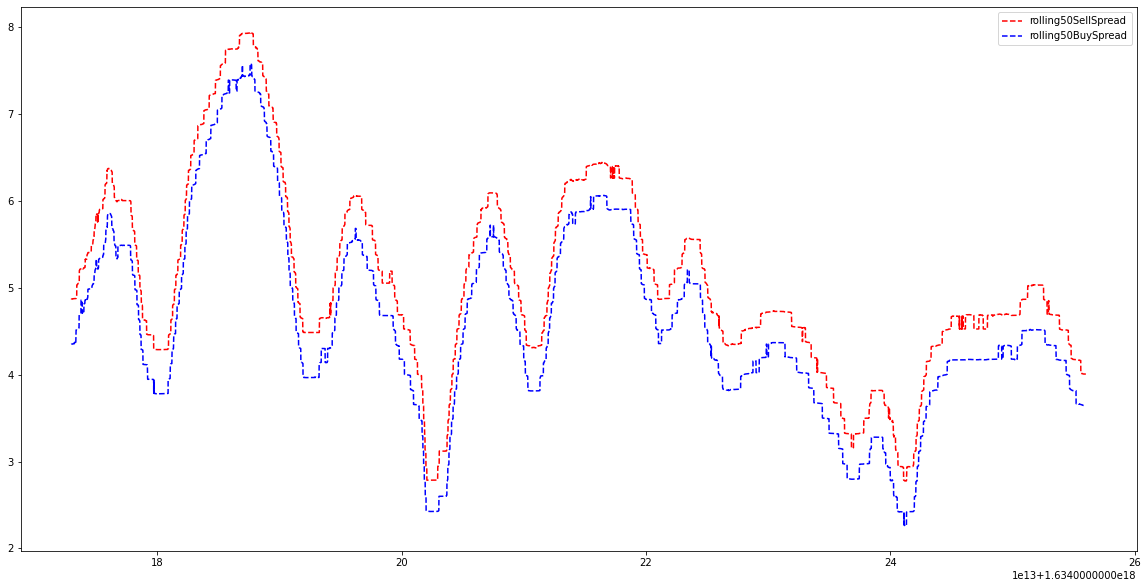

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
sample = 30*1000000000
location = (1634172962587281000 + 1634255999825863000)/2
section = data
# section = data.loc[location - sample:location + sample]
# x = plt.plot(section['Perp_ask-Spot_bid'], label='Perp_ask-Spot_bid', color='red')
x = plt.plot(section['rolling50SellSpread'], label='rolling50SellSpread', linestyle='dashed', color='red')
# x = plt.plot(section['Perp_bid-Spot_ask'], label='Perp_bid-Spot_ask', color='blue')
x = plt.plot(section['rolling50BuySpread'], label='rolling50BuySpread', linestyle='dashed', color='blue')
plt.legend()
plt.show()

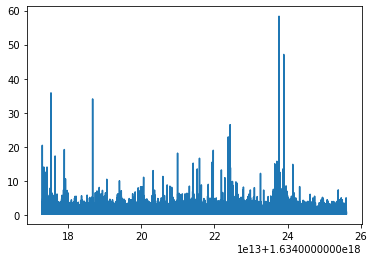

In [34]:
plt.plot(data['Perp_ask-Spot_bid'] - data['Perp_bid-Spot_ask'])

In [37]:
import numpy as np
np.mean(data['Perp_ask-Spot_bid'] - data['Perp_bid-Spot_ask'])

0.4895512788309001